In [1]:
import numpy as np
import pandas as pd
import matplotlib as ml
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ml.style.use('ggplot')
from sklearn import datasets
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### SAMPLE DATASET

HEAD :
    variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0

TAIL :
       variance  skewness  curtosis  entropy  class
1367   0.40614   1.34920   -1.4501 -0.55949      1
1368  -1.38870  -4.87730    6.4774  0.34179      1
1369  -3.75030 -13.45860   17.5932 -2.77710      1
1370  -3.56370  -8.38270   12.3930 -1.28230      1
1371  -2.54190  -0.65804    2.6842  1.19520      1

COUNT OF CLASS LABELS : Counter({0: 762, 1: 610})




<Figure size 720x360 with 0 Axes>

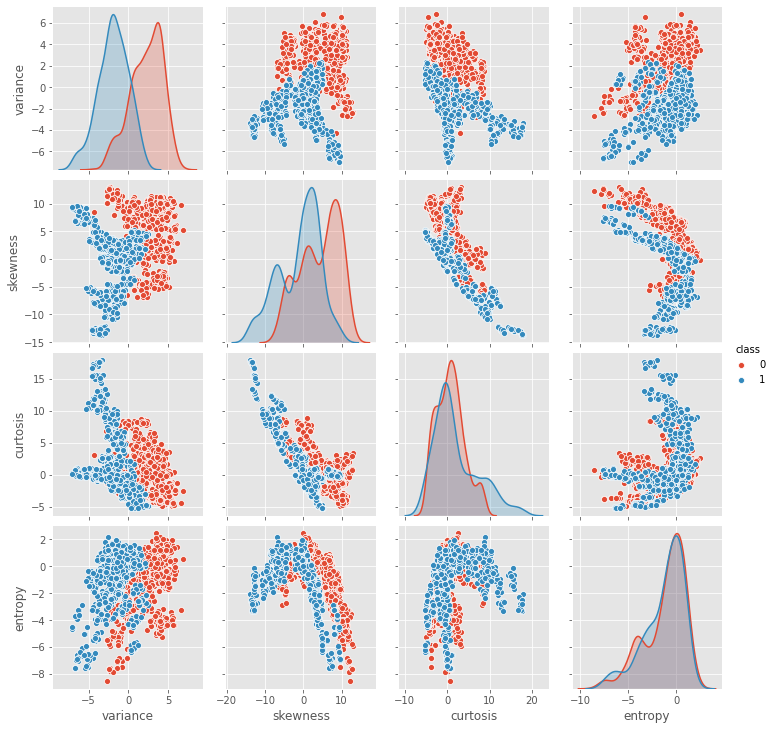

In [2]:
# Data : Bank Note Authentication
data = pd.read_csv('/content/drive/My Drive/BankNote_Authentication.csv')
# Split the dataset into features(X) and labels(Y)
X,Y = data.iloc[:,:4].values,data.iloc[:,4].values
print("HEAD :\n",data.head())
print("\nTAIL :\n",data.tail())
print("\nCOUNT OF CLASS LABELS : {}".format(Counter(data['class'])))
print("\n")
plt.figure(figsize=(10,5))
sns.pairplot(data,hue='class')
plt.show()

### LDA FROM SCRATCH

In [3]:
# Step 1 : Calculating the class-wise means for all 4 dimensions.
mean_k = []
for c in data['class'].unique():
  mean_k.append(np.array((data[data['class']==c].mean()[:4])))    # Excluding the labels
mean_k

[array([ 2.27668601,  4.25662719,  0.79671797, -1.14764028]),
 array([-1.86844256, -0.99357612,  2.14827101, -1.24664075])]

In [4]:
# Step 2 : Computing the within-class(intra) scatter matrix(S_w).
# Equation : S_w = summation((X_nk - m_k).((X_nk - m_k).T)) , where, X_nk = nth point in kth class ; m_k = mean of the kth class.
S_w = np.zeros((4,4))
for i in range(2):   # As there are two classes
    scatter_matrix_class = np.zeros((4,4))
    for j in range(data[data["class"]==i].shape[0]):
        entry, mk = np.array(data.loc[j][:4]).reshape(4,1), mean_k[i].reshape(4,1)
        scatter_matrix_class += (entry-mk).dot((entry-mk).T)
    S_w += scatter_matrix_class
S_w

array([[ 15997.20680745,  10598.25435322,  -6668.5770038 ,
          2469.78109368],
       [ 10598.25435322,  54273.08971098, -22017.11039567,
        -10180.9224334 ],
       [ -6668.5770038 , -22017.11039567,  15846.9785222 ,
          3996.1409538 ],
       [  2469.78109368, -10180.9224334 ,   3996.1409538 ,
          6313.46245398]])

In [5]:
# Step 3 : Computing the between-class(inter) scatter(S_b)
# Equation : S_b = summation((m_k-m).N_k.((m_k-m).T))

mean_total = np.array(data.drop(columns=['class'],axis=1).mean())
S_b = np.zeros((4,4))
for i in range(2):      # As there are two classes
  N_k = data[data['class']==i].shape[0]
  mk = mean_k[i].reshape(4,1)
  m = mean_total.reshape(4,1)
  S_b += N_k*(mk-m).dot((mk-m).T)
S_b

array([[ 5.82112206e+03,  7.37300999e+03, -1.89802442e+03,
         1.39029178e+02],
       [ 7.37300999e+03,  9.33862504e+03, -2.40403016e+03,
         1.76093803e+02],
       [-1.89802442e+03, -2.40403016e+03,  6.18866372e+02,
        -4.53315997e+01],
       [ 1.39029178e+02,  1.76093803e+02, -4.53315997e+01,
         3.32051315e+00]])

In [6]:
# Step 4 : Calculating the covariance matrix 
# Equation : ((S_w^-1).S_b).eigen_vector = eigen_value.eigen_vector
final_matrix = np.linalg.inv(S_w).dot(S_b)
# Step 5 : Calculate eigen values and eigen vector matrices.
eigval, eigvects = np.linalg.eig(final_matrix)
print("EIGEN VECTORS : {}\n\nEIGEN VALUES : {}".format(eigvects,eigval))

EIGEN VECTORS : [[ 0.74101282 -0.35998547 -0.09850181  0.10339716]
 [ 0.35213925  0.48925623  0.31852329 -0.10998952]
 [ 0.57042678  0.79254119  0.94026825 -0.03779242]
 [-0.03887464 -0.05401175  0.06881803  0.98781732]]

EIGEN VALUES : [4.98172096e-01 8.32667268e-17 6.43763073e-17 6.07149904e-19]


In [7]:
# Step 6 : Reverse soritng the eigen values and choosing k(here, k = 2) largest eigen value and their corresponding eigen vectors.
eigen_pairs = [(np.abs(eigval[i]),eigvects[:,i]) for i in range(len(eigval))]
eigen_pairs.sort(key=lambda x : x[0], reverse = True)
# k = 2
W = np.hstack((eigen_pairs[0][1].reshape(4,1),eigen_pairs[1][1].reshape(4,1)))

# Step 7 : Transforming the data to the new subspace.
lda_x = X.dot(W)
lda_x

array([[ 4.15134342,  0.73546189],
       [ 4.89901958,  0.48992222],
       [ 3.0291836 , -1.16325031],
       ...,
       [ 2.62526958,  8.85868128],
       [ 1.52652301,  7.07281423],
       [-0.63062559,  2.6558811 ]])

In [8]:
data['LDA_1'],data['LDA_2'] = X[:,0],X[:,1]
data

,variance,skewness,curtosis,entropy,class,LDA_1,LDA_2
0,3.62160,8.66610,-2.8073,-0.44699,0,3.62160,8.66610
1,4.54590,8.16740,-2.4586,-1.46210,0,4.54590,8.16740
2,3.86600,-2.63830,1.9242,0.10645,0,3.86600,-2.63830
3,3.45660,9.52280,-4.0112,-3.59440,0,3.45660,9.52280
4,0.32924,-4.45520,4.5718,-0.98880,0,0.32924,-4.45520
...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,0.40614,1.34920
1368,-1.38870,-4.87730,6.4774,0.34179,1,-1.38870,-4.87730
1369,-3.75030,-13.45860,17.5932,-2.77710,1,-3.75030,-13.45860
1370,-3.56370,-8.38270,12.3930,-1.28230,1,-3.56370,-8.38270


<Figure size 720x360 with 0 Axes>

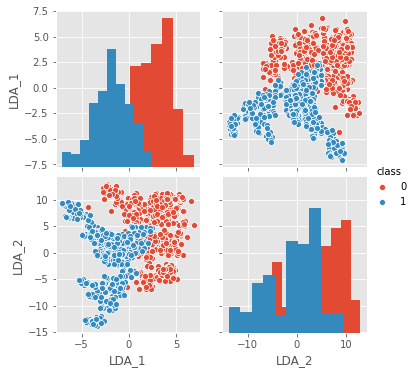

In [9]:
plt.figure(figsize=(10,5))
sns.pairplot(data[['LDA_1','LDA_2','class']],hue='class',diag_kind='hist')
plt.show()

### COMBINING EVERYTHING INSIDE A CLASS (Upcoming)